# Predicting with Tabular Data

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 20/01/25   | Martin | Create  | Started working on ch7: tabular data | 
| 04/02/25   | Martin | Update  | Completed most sections. Remaining putting it all together | 
| 10/02/25   | Martin | Complete  | Completed putting it all together section | 

# Content

* [Introduction](#introduction)
* [Processing Dates](#processing-dates)
* [Processing Categorical Data](#processing-categorical-data)
* [Processing Ordinal Data](#processing-ordinal-data)
* [Processing High Cardinality Data](#processing-high-cardinality-data)
* [Putting It All Together](#putting-it-all-together)

# Introduction

Most data is stored in tables. This type of data is known as tabular data.

Common challenges when using DNN with tabular data:

1. Mixed features data types (e.g string, float, int, text, ...)
2. Data in sparse format - more zeros than non-zeros - DNN have difficults converting these into meaningful gradients to apply backpropogation
3. No state-of-the-art architecture to resolve it
4. Less data is available
5. Less interpretable
6. Alternative models (e.g XGBoost, LightGBM, CatBoost) perform better

# Processing Numerical Data

Types of numerical data:

* Data expressed as a floating number
* Integer that has a certain number of unique values (or order - ordinal)
* Interger data is not representing a class or label (standard categorical feature)

Potential issues:

* Missing data
* Constant values - slows down computation and interferes with bias in each neuron
* Skewed distributions
* Non-standardised data (extreme values)

🚨 __CRITICAL: Have to deal with these issues before passing data to neural network, else it will return errors__

Build a scikit-learn pipeline with the following functions:

* Minimum acceptable variance for a feature to be kept - else there will be unwanted constants in the network
* Inputer for missing values
  - 📜 __NOTE:__ More sophisticated inputation methods can utilise information from other variables to perform inputation.
  - Inputation is critical because sometimes missing values represent some relationship that is hidden within the dataset but is not captured numerically
  - Potentially use binary feature encoding to indicate missing values
* Whether to transform distribution of variables to resemble a more symetric/ expected distribution
* Rescale variables or outputs based on their statistical distribution (Standardisation, Normalisation, etc.)

In [30]:
from catboost.datasets import amazon

X, Xt = amazon()

y = X['ACTION'].apply(lambda x: 1 if x == 1 else 0).values
X.drop(['ACTION'], axis=1, inplace=True)

In [31]:
X.head()

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [32]:
import numpy as np
import pandas as pd

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline

In [33]:
def assemble_numeric_pipeline(
  variance_threshold=0.0,
  imputer='mean',
  multivariate_imputer=False,
  add_indicator=True,
  quantile_transformer='normal',
  scaler=True
):
  numeric_pipeline = []
  
  # Variance Threshold - Removes all low-variance features based on threshold specified
  if variance_threshold is not None:
    if isinstance(variance_threshold, float):
      numeric_pipeline.append(('var_filter', VarianceThreshold(threshold=variance_threshold)))
    else:
      numeric_pipeline.append(('var_filter', VarianceThreshold()))
  
  # Imputer - Replaces NaN values with specified logic
  ## 2 types of imputers
  ##   1. Multivariate Imputer - builds a regression model from other features and existing data
  ##                             and fills NaN values with predictions of model
  ##   2. Simple Imputer - Use summary statistics from existing values to fill missing data

  # Add Indicator - adds a binary feature denoting where the missing values were
  if imputer is not None:
    if multivariate_imputer:
      numeric_pipeline.append(('imputer', IterativeImputer(
        estimator=ExtraTreesRegressor(n_estimators=100, n_jobs=-2),
        initial_strategy=imputer,
        add_indicator=add_indicator
      )))
    else:
      numeric_pipeline.append(('imputer', SimpleImputer(
        strategy=imputer,
        add_indicator=add_indicator
      )))

  # Quantile Transformer - Converts features to follow a uniform or normal distribution based on
  #                        the quantile information
  ## - Estimates the cumulative distribution function using existing data
  ## - Values are then mapped to the distribution
  ## - Unseen or extreme values are mapped to the bounds
  if quantile_transformer is not None:
      numeric_pipeline.append(('transformer', QuantileTransformer(
        n_quantiles=100,
        output_distribution=quantile_transformer,
        random_state=42
      )))
  
  # Scaler - Scales the output of the variables to the standard normal distribution
  if scaler:
    numeric_pipeline.append(('scaler', StandardScaler()))
  
  return Pipeline(steps=numeric_pipeline)

In [34]:
numeric_pipeline = assemble_numeric_pipeline(
  variance_threshold=0.0,
  imputer='mean',
  multivariate_imputer=False,
  add_indicator=True,
  quantile_transformer='normal',
  scaler=True
)

In [35]:
example = pd.DataFrame([[1, 2, 3, np.nan], [1, 3, np.nan, 4], [1, 2, 2, 2]], columns = ['a', 'b', 'c', 'd'])
example.head()

,a,b,c,d
0,1,2,3.0,NaN
1,1,3,NaN,4.0
2,1,2,2.0,2.0


In [36]:
numeric_pipeline.fit(example)

d:\Software\venv\py311_env\Lib\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (100) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(


Pipeline(steps=[('var_filter', VarianceThreshold()),
                ('imputer', SimpleImputer(add_indicator=True)),
                ('transformer',
                 QuantileTransformer(n_quantiles=100,
                                     output_distribution='normal',
                                     random_state=42)),
                ('scaler', StandardScaler())])

In [37]:
np.round(numeric_pipeline.transform(example), 3)

array([[-0.707,  1.225, -0.   , -0.707,  1.414],
       [ 1.414, -0.   ,  1.225,  1.414, -0.707],
       [-0.707, -1.225, -1.225, -0.707, -0.707]])

## Things to Note

* Tabular data requires transformations that are more complex and non-deterministic because they involve learning from existing values (e.g computing the mean before imputing)
* Need to keep track of many parameters - sklearn stores using `fit` & `transform`
* Pipeline returns a `numpy.array`, but transformation sequence might change column sequencing (e.g with the new binary variable that indicates missing variables)

In [38]:
# Function to identify columns
def derive_numeric_columns(df, pipeline):
  columns = df.columns
  if 'var_filter' in pipeline.named_steps:
    threshold = pipeline.named_steps.var_filter.threshold
    columns = columns[pipeline.named_steps.var_filter.variances_ > threshold]
  
  if 'imputer' in pipeline.named_steps:
    missing_cols = pipeline.named_steps.imputer.indicator_.features_
    if len(missing_cols) > 0:
      columns = columns.append(columns[missing_cols] + '_missing')
    return columns

In [39]:
derive_numeric_columns(example, numeric_pipeline)

Index(['b', 'c', 'd', 'c_missing', 'd_missing'], dtype='object')

---

# Processing Dates

* NNs cannot process dates => Need to transform them by __separating the numeric elements__
* $sine$ and $cosine$ functions are used to denote time values since they are cyclical
  - Transformation makes it into a sine/ cosine function
  - Looks like the shapes on a clock

Recipe below creates a custom pipeline that implements the `fit` and `transform` methods.

In [40]:
from sklearn.base import BaseEstimator, TransformerMixin

In [41]:
class DateProcessor(BaseEstimator, TransformerMixin):
  def __init__(self, date_format='%d/%m/%Y', hours_secs=False):
    self.format = date_format
    self.columns = None

    # Implementing the sine and cosine cyclical methods for formats
    self.time_transformations = [
      ('day_sin', lambda x: np.sin(2*np.pi*x.dt.day/31)),
      ('day_cos', lambda x: np.cos(2*np.pi*x.dt.day/31)),
      ('dayofweek_sin', lambda x: np.sin(2*np.pi*x.dt.dayofweek/6)),
      ('dayofweek_cos', lambda x: np.cos(2*np.pi*x.dt.dayofweek/6)),
      ('month_sin', lambda x: np.sin(2*np.pi*x.dt.month/12)),
      ('month_cos', lambda x: np.cos(2*np.pi*x.dt.month/12)),
      ('year', lambda x: (x.dt.year - x.dt.year.min()) / (x.dt.year.max() - x.dt.year.min()))
    ]

    if hours_secs:
      # Additional time transformations for hour/ minute information
      self.time_transformations = [
        ('hour_sin', lambda x: np.sin(2*np.pi*x.dt.hour/23)),
        ('hour_cos', lambda x: np.cos(2*np.pi*x.dt.hour/23)),
        ('minute_sin', lambda x: np.sin(2*np.pi*x.dt.minute/59)),
        ('minute_cos', lambda x: np.cos(2*np.pi*x.dt.minute/59))
      ] + self.time_transformations
    
  def fit(self, X, y=None, **fit_params):
    self.columns = self.transform(X.iloc[0:1, :]).columns
    return self
  
  def transform(self, X, y=None, **fit_params):
    transformed = []
    for col in X.columns:
      time_column = pd.to_datetime(X[col], format=self.format)
      for label, func in self.time_transformations:
        transformed.append(func(time_column))
        transformed[-1].name = transformed[-1].name + '_' + label
    transformed = pd.concat(transformed, axis=1)
    return transformed
  
  def fit_transform(self, X, y=None, **fit_params):
    self.fit(X, y, **fit_params)
    return self.transform(X)

In [42]:
example = pd.DataFrame({'date_1': ['04/12/2018', '05/12/2019', '07/12/2020'],
                        'date_2': ['12/5/2018', '15/5/2015', '18/5/2016'],
                        'date_3': ['25/8/2019', '28/8/2018', '29/8/2017']})
example                      

,date_1,date_2,date_3
0,04/12/2018,12/5/2018,25/8/2019
1,05/12/2019,15/5/2015,28/8/2018
2,07/12/2020,18/5/2016,29/8/2017


In [43]:
DateProcessor().fit_transform(example)

,date_1_day_sin,date_1_day_cos,date_1_dayofweek_sin,date_1_dayofweek_cos,date_1_month_sin,date_1_month_cos,date_1_year,date_2_day_sin,date_2_day_cos,date_2_dayofweek_sin,...,date_2_month_sin,date_2_month_cos,date_2_year,date_3_day_sin,date_3_day_cos,date_3_dayofweek_sin,date_3_dayofweek_cos,date_3_month_sin,date_3_month_cos,date_3_year
0,0.724793,0.688967,8.660254e-01,0.5,-2.449294e-16,1.0,0.0,0.651372,-0.758758,-0.866025,...,0.5,-0.866025,1.000000,-0.937752,0.347305,-2.449294e-16,1.0,-0.866025,-0.5,1.0
1,0.848644,0.528964,1.224647e-16,-1.0,-2.449294e-16,1.0,0.5,0.101168,-0.994869,-0.866025,...,0.5,-0.866025,0.000000,-0.571268,0.820763,8.660254e-01,0.5,-0.866025,-0.5,0.5
2,0.988468,0.151428,0.000000e+00,1.0,-2.449294e-16,1.0,1.0,-0.485302,-0.874347,0.866025,...,0.5,-0.866025,0.333333,-0.394356,0.918958,8.660254e-01,0.5,-0.866025,-0.5,0.0


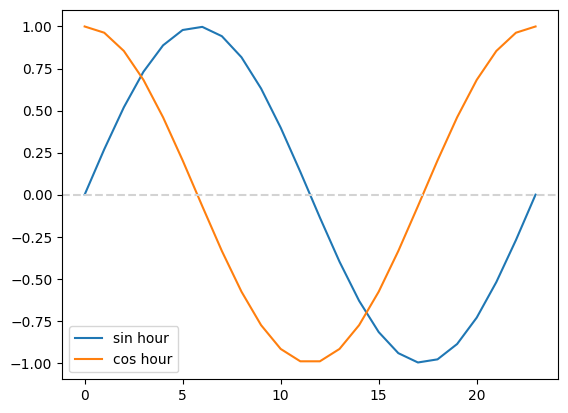

In [44]:
# Showing what the time sine and cosine transformations look like on a plot
import matplotlib.pyplot as plt

sin_time = np.array([[t, np.sin(2*np.pi*t/23)] for t in range(0, 24)])
cos_time = np.array([[t, np.cos(2*np.pi*t/23)] for t in range(0, 24)])

plt.plot(sin_time[:,0], sin_time[:,1], label='sin hour')
plt.plot(cos_time[:,0], cos_time[:,1], label='cos hour')
plt.axhline(y=0.0, linestyle='--', color='lightgray')
plt.legend()
plt.show()

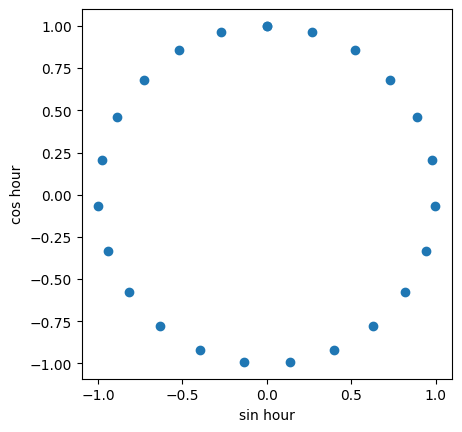

In [45]:
ax = plt.subplot()
ax.set_aspect('equal')
ax.set_xlabel('sin hour')
ax.set_ylabel('cos hour')
plt.scatter(sin_time[:,1], cos_time[:,1])
plt.show()

## About time transformations

__From Plot 1__

* Each time component consists of a sine and cosine component
  - 🥬 e.g 04/12/2018 - (0.724793, 0.688967)
* 0 and 24 (the start and end times) represent the same value just at different points of the day, so numerically they are the same
* What defines the cycle depends on the time frame being transformed - a year? a day? etc.

---

# Processing Categorical Data

* _Qualitative_ - Categorical features that each represent a unique value. Each is called a _level_ and the feature is called a _factor_
* Some data might contain some additional information encoded within them (e.g 1st, 2nd, 3rd place have some order embedded)
  - ⚠️ __CAUTION:__ If you group them together or imply some additional details to the categorical variable, these are considered hypotheses
* _One-hot encoding_ - Creating a binary feature from EACH unique categorical value
  - Too many levels creates sparse data
  - Sparse data is not good for DNN because it prevent backpropogation from functioning well
  - 📜 __NOTE:__ Should only be used for low-cardinality variables (<255)

In [46]:
from sklearn.preprocessing import OneHotEncoder

In [47]:
class ToString(BaseEstimator, TransformerMixin):
  """Converts column type to string"""
  def fit(self, X, y=None, **fit_params):
    return self

  def transform(self, X, y=None, **fit_params):
    return X.astype(str)
  
  def fit_transform(self, X, y=None, **fit_params):
    self.fit(X, y, **fit_params)
    return self.transform(X)

In [48]:
categorical_pipeline = Pipeline(steps=[
  ('string_converter', ToString()),
  ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
  ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [49]:
example = pd.DataFrame([['car', 1234], ['house', 6543], ['tree', 3456]], columns=['object', 'code'])
example

,object,code
0,car,1234
1,house,6543
2,tree,3456


In [50]:
categorical_pipeline.fit_transform(example).todense()

matrix([[1., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0.]])

In [51]:
def derive_ohe_columns(df, pipeline):
    return [str(col) + '_' + str(lvl) for col, lvls in zip(df.columns, pipeline.named_steps.onehot.categories_) for lvl in lvls]

derive_ohe_columns(example, categorical_pipeline)

['object_car',
 'object_house',
 'object_tree',
 'code_1234',
 'code_3456',
 'code_6543']

---

# Processing Ordinal Data

* The scale is different than the distance between each value if processing ordinal data like categorical data
* Closer to a numerical value because numerical data has a sense of "larger" and "smaller"
* Combine the interpretation of both numerical and categorical

Create separate pipelines:

1. __Ordinal -> Numeric__ - Preserve the ordering of the original feature
2. __Ordinal -> Categorical__ - Preserve the step information between ordinal grades

Final data will be 2 values

In [52]:
from sklearn.preprocessing import OrdinalEncoder

In [53]:
oe = OrdinalEncoder(categories=[
  ['first', 'second', 'third'],
  ['very much', 'average', 'very little']
])

categorical_pipeline = Pipeline(steps=[
  ('string_converter', ToString()),
  ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
  ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [54]:
example = pd.DataFrame([['first', 'very much'], ['second', 'very little'], ['third', 'average']],
                       columns = ['rank', 'importance'])
example

,rank,importance
0,first,very much
1,second,very little
2,third,average


In [55]:
np.hstack((oe.fit_transform(example), categorical_pipeline.fit_transform(example).todense()))

matrix([[0., 0., 1., 0., 0., 0., 0., 1.],
        [1., 2., 0., 1., 0., 0., 1., 0.],
        [2., 1., 0., 0., 1., 1., 0., 0.]])

In [56]:
example.columns.tolist() + derive_ohe_columns(example, categorical_pipeline)

['rank',
 'importance',
 'rank_first',
 'rank_second',
 'rank_third',
 'importance_average',
 'importance_very little',
 'importance_very much']

---

# Processing High-Cardinality Data

Utilise an embedding layer

* _Embedding_ - Matrix of weights that convert high-cardinality cateogrical inputs into a lower-dimensionality numerical output
  - A weighted linear combination whose weights are optimised to convert categories into numbers
  - Under the hood: A small neural network is trained to mix and combine the inputs together into a smaller output layer
  - Only works on numerical data
* Must be able to handle unseen categories and still fit the fit/ transform workflow

In [57]:
from sklearn.preprocessing import LabelEncoder

In [58]:
class LEncoder(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.encoders = {}
    self.dictionary_size = []
    self.unk = -1
  
  def fit(self, X, y=None, **fit_params):
    for col in range(X.shape[1]):
      le = LabelEncoder()
      # Replace NA values with a "class" called _nan
      le.fit(X.iloc[:, col].fillna('_nan'))
      # Dictionary contains the level as key and the numerical label as the value
      le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
    
      # set the default nan value to the max value
      if "_nan" not in le_dict:
        max_value = max(le_dict.values())
        le_dict['_nan'] = max_value
      
      # _unk represents unknown values - defaults to returning the max values
      max_value = max(le_dict.values())
      le_dict['_unk'] = max_value

      self.unk = max_value
      self.dictionary_size.append(len(le_dict))
      col_name = X.columns[col]
      self.encoders[col_name] = le_dict
    
    return self
  
  def transform(self, X, y=None, **fit_params):
    output = []
    for col in range(X.shape[1]):
      col_name = X.columns[col]
      le_dict = self.encoders[col_name]
      # Returning the label encoded values including unseen ones returned as _unk
      emb = X.iloc[:, col].fillna('_nan').apply(lambda x: le_dict.get(x, le_dict['_unk'])).values
      output.append(pd.Series(emb, name=col_name).astype(np.int32))
    return output
  
  def fit_transform(self, X, y=None, **fit_params):
    self.fit(X, y, **fit_params)
    return self.transform(X)



In [59]:
import string, random

def random_id(length=8):
  voc = string.ascii_lowercase + string.digits
  return ''.join(random.choice(voc) for i in range(length))

example = pd.DataFrame({'high_cat_1': [random_id(length=2) for i in range(500)], 
                        'high_cat_2': [random_id(length=3) for i in range(500)], 
                        'high_cat_3': [random_id(length=4) for i in range(500)]})

In [60]:
example.head()

,high_cat_1,high_cat_2,high_cat_3
0,rb,xza,umyk
1,ix,u5a,kgvn
2,mo,3l2,qnwx
3,5c,7yk,fhe8
4,5w,k1p,nkow


In [61]:
le = LEncoder()
le.fit_transform(example)

[0      310
 1      221
 2      255
 3       55
 4       65
       ... 
 495     88
 496     76
 497     62
 498    293
 499    199
 Name: high_cat_1, Length: 500, dtype: int32,
 0      467
 1      408
 2       56
 3      115
 4      278
       ... 
 495     43
 496    343
 497    298
 498    133
 499    325
 Name: high_cat_2, Length: 500, dtype: int32,
 0      425
 1      283
 2      370
 3      213
 4      328
       ... 
 495     12
 496    358
 497    480
 498    191
 499    105
 Name: high_cat_3, Length: 500, dtype: int32]

In [62]:
le.dictionary_size

[414, 501, 501]

In [63]:
le.encoders

{'high_cat_1': {'01': 0,
  '04': 1,
  '05': 2,
  '06': 3,
  '07': 4,
  '08': 5,
  '0h': 6,
  '0i': 7,
  '0j': 8,
  '0k': 9,
  '0l': 10,
  '0q': 11,
  '0w': 12,
  '0x': 13,
  '12': 14,
  '16': 15,
  '17': 16,
  '19': 17,
  '1b': 18,
  '1c': 19,
  '1f': 20,
  '1h': 21,
  '1j': 22,
  '1o': 23,
  '1p': 24,
  '1x': 25,
  '23': 26,
  '24': 27,
  '25': 28,
  '2a': 29,
  '2b': 30,
  '2d': 31,
  '2e': 32,
  '2f': 33,
  '2l': 34,
  '2p': 35,
  '37': 36,
  '3b': 37,
  '3f': 38,
  '3h': 39,
  '3m': 40,
  '3q': 41,
  '3s': 42,
  '3t': 43,
  '3v': 44,
  '44': 45,
  '49': 46,
  '4d': 47,
  '4e': 48,
  '4i': 49,
  '4k': 50,
  '4s': 51,
  '4u': 52,
  '50': 53,
  '5a': 54,
  '5c': 55,
  '5d': 56,
  '5e': 57,
  '5h': 58,
  '5k': 59,
  '5m': 60,
  '5p': 61,
  '5q': 62,
  '5s': 63,
  '5u': 64,
  '5w': 65,
  '60': 66,
  '61': 67,
  '62': 68,
  '65': 69,
  '69': 70,
  '6l': 71,
  '6m': 72,
  '6o': 73,
  '6q': 74,
  '6t': 75,
  '71': 76,
  '72': 77,
  '74': 78,
  '75': 79,
  '7d': 80,
  '7i': 81,
  '7k': 82,


## Things to note

* The `LEncoder` class extends the ootb encoder variable with the ability to handle missing data
* Embeddings require ALL possible labels, including __missing__ and __unknown__ labels

---

# Putting It All Together

Create a single class that uses all different fit transform operations

* `FeatureUnion` - Concatenate results of multiple transformer objects. Combines several feature extraction mechanisms into a single transformer

In [ ]:
from sklearn.pipeline import FeatureUnion

In [ ]:
class TabularTransformer(BaseEstimator, TransformerMixin):

  def instantiate(self, param):
    if isinstance(param, str):
      return [param]
    elif isinstance(param, list):
      return param
    else:
      return None
  
  def __init__(
    self,
    numeric=None,
    dates=None,
    ordinal=None,
    cat=None,
    highcat=None,
    variance_threshold=0.0,
    missing_imputer='mean',
    use_multivariate_imputer=False,
    add_missing_indicator=True,
    quantile_transformer='normal',
    scaler=True,
    ordinal_categories='auto',
    date_format='%d/%m/%Y',
    hours_secs=False
  ):
    self.numeric = self.instantiate(numeric)
    self.dates = self.instantiate(dates)
    self.ordinal = self.instantiate(ordinal)
    self.cat = self.instantiate(cat)
    self.highcat = self.instantiate(highcat)
    self.columns = None
    self.vocabulary = None

    # Pipeline for numeric values
    self.numeric_process = assemble_numeric_pipeline(variance_threshold=variance_threshold, 
                                                         imputer=missing_imputer, 
                                                         multivariate_imputer=use_multivariate_imputer, 
                                                         add_indicator=add_missing_indicator,
                                                         quantile_transformer=quantile_transformer,
                                                         scaler=scaler)
    # Pipeline for date values
    self.dates_process = DateProcessor(date_format=date_format, hours_secs=hours_secs)

    # Pipeline for ordinal values
    self.ordinal_process = FeatureUnion([('ordinal', OrdinalEncoder(categories=ordinal_categories)),
                                         ('categorial', Pipeline(steps=[('string_converter', ToString()),
                                         ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                         ('onehot', OneHotEncoder(handle_unknown='ignore'))]))]) 

    # Pipeline for categorical values
    self.cat_process = Pipeline(steps=[('string_converter', ToString()),
                                       ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    # Pipeline for high cardinality values
    self.highcat_process = LEncoder()
  
  def fit(self, X, y=None, **fit_params):
    self.columns = []
    if self.numeric:
      self.numeric_process.fit(X[self.numeric])
      self.columns += derive_numeric_columns(X[self.numeric], self.numeric_process).to_list()

    if self.dates:
      self.dates_process.fit(X[self.dates])
      self.columns += self.dates_process.columns.to_list()

    if self.ordinal:
      self.ordinal_process.fit(X[self.ordinal])
      self.columns += derive_ohe_columns(X[self.cat], self.cat_process)
    
    if self.highcat:
      self.highcat_process.fit(X[self.highcat])
      self.vocabulary = dict(zip(self.highcat, self.highcat_process.dictionary_size))
      self.columns = [self.columns, self.highcat]
    
    return self
  
  def transform(self, X, y=None, **fit_params):
    flat_matrix = []
    if self.numeric:
      flat_matrix.append(self.numeric_process.transform(X[self.numeric]).astype(np.float32))

    if self.dates:
      flat_matrix.append(self.dates_process.transform(X[self.dates]).values.astype(np.float32))

    if self.ordinal:
      flat_matrix.append(self.ordinal_process.transform(X[sel.ordinal]).todense().astype(np.float32))
    
    if self.cat:
      self.flat_matrix.append(self.cat_process.transform(X[self.cat]).todense().astype(np.float32))
    
    if self.highcat:
      cat_vectors = self.highcat_process.transform(X[self.highcat])
      if len(flat_matrix) > 0:
        return [np.hstack(flat_matrix)] +  cat_vectors
      else:
        return cat_vectors
    else:
      return np.hstack(flat_matrix)
  
  def fit_transform(self, X, y=None, **fit_params):
    self.fit(X, y, **fit_params)
    return self.transform(X)

In [66]:
example = pd.concat([pd.DataFrame([[1, 2, 3, np.nan], [1, 3, np.nan, 4], [1, 2, 2, 2]], columns = ['a', 'b', 'c', 'd']),
                     pd.DataFrame({'date_1': ['04/12/2018', '05/12/2019', '07/12/2020'],
                                    'date_2': ['12/5/2018', '15/5/2015', '18/5/2016'],
                                    'date_3': ['25/8/2019', '28/8/2018', '29/8/2017']}),
                     pd.DataFrame([['first', 'very much'], ['second', 'very little'], ['third', 'average']],
                                   columns = ['rank', 'importance']),
                     pd.DataFrame([['car', 1234], ['house', 6543], ['tree', 3456]], columns=['object', 'code']),
                     pd.DataFrame({'high_cat_1': [random_id(length=2) for i in range(3)], 
                                    'high_cat_2': [random_id(length=3) for i in range(3)], 
                                    'high_cat_3': [random_id(length=4) for i in range(3)]})
                    ], axis=1)

numeric_vars = ['a', 'b', 'c', 'd']
date_vars = ['date_1', 'date_2', 'date_3']
ordinal_vars = ['rank', 'importance']
cat_vars = ['object', 'code']
highcat_vars = ['high_cat_1', 'high_cat_2', 'high_cat_3']

In [67]:
tt = TabularTransformer(
  numeric=numeric_vars,
  dates=date_vars,
  ordinal=ordinal_vars,
  cat=cat_vars,
  highcat=highcat_vars
)

In [ ]:
input_list = tt.fit_transform(example)

In [ ]:
print([(item.shape, item.dtype) for item in input_list])

In [ ]:
tt.columns

In [ ]:
tt.vocabulary